In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import yfinance as yf
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.model_selection import GridSearchCV

In [2]:



warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:

ticker = yf.Ticker("MSFT")

In [4]:
# Define the start and end dates
start_date = "2016-06-14"

In [5]:

df = ticker.history(start=start_date, end=None)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,44.975201,45.155459,44.677768,44.912109,42577100,0.0,0.0
2016-06-15 00:00:00-04:00,44.867045,45.173489,44.785927,44.785927,33757600,0.0,0.0
2016-06-16 00:00:00-04:00,44.632708,45.488950,44.623693,45.416843,31188600,0.0,0.0
2016-06-17 00:00:00-04:00,45.434864,45.452890,44.903093,45.182499,45710500,0.0,0.0
2016-06-20 00:00:00-04:00,45.642166,45.813417,45.092369,45.128422,35607900,0.0,0.0


In [6]:

candlestick_trace = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick'
)

In [7]:

layout = go.Layout(
    title='MSFT Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

In [8]:

fig = go.Figure(data=[candlestick_trace], layout=layout)

fig.update_layout(xaxis_rangeslider_visible=False)


fig.show()

In [9]:
# Move column 'Close' to the first position
col_close = df.pop('Close')
df.insert(0, 'Close', col_close)
df.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,44.912109,44.975201,45.155459,44.677768,42577100,0.0,0.0
2016-06-15 00:00:00-04:00,44.785927,44.867045,45.173489,44.785927,33757600,0.0,0.0
2016-06-16 00:00:00-04:00,45.416843,44.632708,45.488950,44.623693,31188600,0.0,0.0
2016-06-17 00:00:00-04:00,45.182499,45.434864,45.452890,44.903093,45710500,0.0,0.0
2016-06-20 00:00:00-04:00,45.128422,45.642166,45.813417,45.092369,35607900,0.0,0.0


In [10]:
df.shape

(1919, 7)

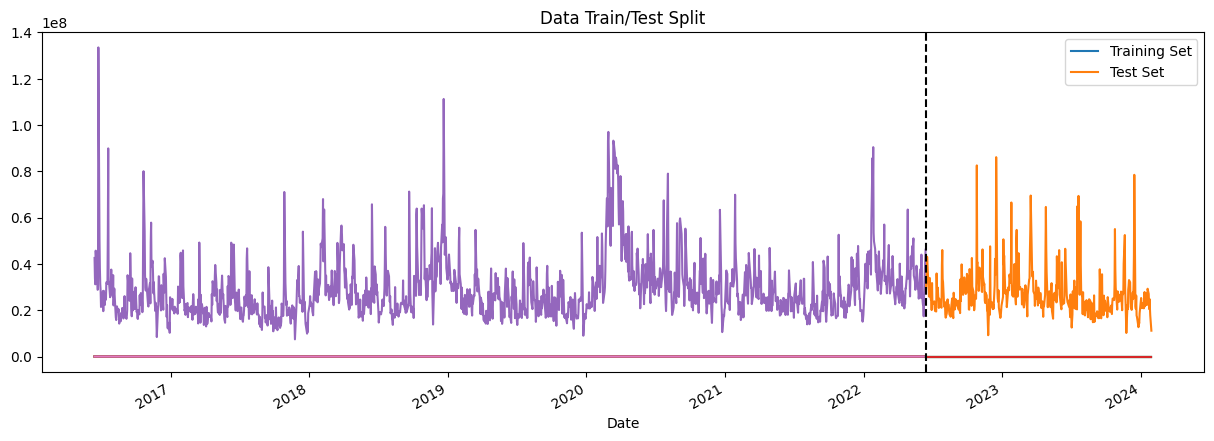

In [11]:
train = df.loc[df.index < '2022-06-14']
test = df.loc[df.index >= '2022-06-14']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2022-06-14', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [12]:
dates = df.index

In [14]:
# Normalize numeric features only
numeric_columns = ['Open', 'High', 'Low', 'Close']
scaler = MinMaxScaler(feature_range=(0, 15)).fit(df[numeric_columns])
df[numeric_columns] = scaler.transform(df[numeric_columns])

In [15]:
time_step = 7 

In [18]:
for i in range(1, time_step + 1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

In [20]:
data_with_lags = df.dropna()

In [21]:
lag_column_names = [f'Close(t-{i})' for i in range(1, time_step + 1)]


In [22]:
# Define X and y
X = data_with_lags[lag_column_names]
y = data_with_lags['Close']

In [23]:
df

,Close,Open,High,Low,Volume,Dividends,Stock Splits,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,,,,,,,
2016-06-14 00:00:00-04:00,0.052079,0.036604,0.035205,0.057294,42577100,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-15 00:00:00-04:00,0.046871,0.032122,0.035946,0.061788,33757600,0.0,0.0,0.052079,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-16 00:00:00-04:00,0.072910,0.022411,0.048917,0.055047,31188600,0.0,0.0,0.046871,0.052079,NaN,NaN,NaN,NaN,NaN
2016-06-17 00:00:00-04:00,0.063238,0.055652,0.047434,0.066656,45710500,0.0,0.0,0.072910,0.046871,0.052079,NaN,NaN,NaN,NaN
2016-06-20 00:00:00-04:00,0.061006,0.064243,0.062258,0.074520,35607900,0.0,0.0,0.063238,0.072910,0.046871,0.052079,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-23 00:00:00-05:00,14.661964,14.572752,14.599530,14.567905,20525900,0.0,0.0,14.563324,14.652472,14.454364,14.272766,14.305784,14.231494,14.073009
2024-01-24 00:00:00-05:00,14.813020,14.812691,14.856505,14.838796,24867000,0.0,0.0,14.661964,14.563324,14.652472,14.454364,14.272766,14.305784,14.231494
2024-01-25 00:00:00-05:00,14.908359,14.927895,14.913246,14.925215,21021200,0.0,0.0,14.813020,14.661964,14.563324,14.652472,14.454364,14.272766,14.305784


In [25]:
# Split the data into training and testing sets
split_index = int(len(X) * 0.7875)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [26]:
y_train

Date
2016-06-23 00:00:00-04:00    0.129453
2016-06-24 00:00:00-04:00    0.052079
2016-06-27 00:00:00-04:00    0.000000
2016-06-28 00:00:00-04:00    0.037571
2016-06-29 00:00:00-04:00    0.078489
                               ...   
2022-06-08 00:00:00-04:00    9.206348
2022-06-09 00:00:00-04:00    8.977568
2022-06-10 00:00:00-04:00    8.497212
2022-06-13 00:00:00-04:00    8.060412
2022-06-14 00:00:00-04:00    8.151192
Name: Close, Length: 1505, dtype: float64

In [27]:
X_train

,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,
2016-06-23 00:00:00-04:00,0.095229,0.102669,0.061006,0.063238,0.072910,0.046871,0.052079
2016-06-24 00:00:00-04:00,0.129453,0.095229,0.102669,0.061006,0.063238,0.072910,0.046871
2016-06-27 00:00:00-04:00,0.052079,0.129453,0.095229,0.102669,0.061006,0.063238,0.072910
2016-06-28 00:00:00-04:00,0.000000,0.052079,0.129453,0.095229,0.102669,0.061006,0.063238
2016-06-29 00:00:00-04:00,0.037571,0.000000,0.052079,0.129453,0.095229,0.102669,0.061006
...,...,...,...,...,...,...,...
2022-06-08 00:00:00-04:00,9.291427,9.138770,9.190470,9.376100,9.288172,9.265780,9.321552
2022-06-09 00:00:00-04:00,9.206348,9.291427,9.138770,9.190470,9.376100,9.288172,9.265780
2022-06-10 00:00:00-04:00,8.977568,9.206348,9.291427,9.138770,9.190470,9.376100,9.288172


In [28]:
X_test

,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,
2022-06-15 00:00:00-04:00,8.151192,8.060412,8.497212,8.977568,9.206348,9.291427,9.138770
2022-06-16 00:00:00-04:00,8.447140,8.151192,8.060412,8.497212,8.977568,9.206348,9.291427
2022-06-17 00:00:00-04:00,8.170732,8.447140,8.151192,8.060412,8.497212,8.977568,9.206348
2022-06-21 00:00:00-04:00,8.279829,8.170732,8.447140,8.151192,8.060412,8.497212,8.977568
2022-06-22 00:00:00-04:00,8.527743,8.279829,8.170732,8.447140,8.151192,8.060412,8.497212
...,...,...,...,...,...,...,...
2024-01-23 00:00:00-05:00,14.563324,14.652472,14.454364,14.272766,14.305784,14.231494,14.073009
2024-01-24 00:00:00-05:00,14.661964,14.563324,14.652472,14.454364,14.272766,14.305784,14.231494
2024-01-25 00:00:00-05:00,14.813020,14.661964,14.563324,14.652472,14.454364,14.272766,14.305784


In [29]:
y.iloc[split_index:]

Date
2022-06-15 00:00:00-04:00     8.447140
2022-06-16 00:00:00-04:00     8.170732
2022-06-17 00:00:00-04:00     8.279829
2022-06-21 00:00:00-04:00     8.527743
2022-06-22 00:00:00-04:00     8.502911
                               ...    
2024-01-23 00:00:00-05:00    14.661964
2024-01-24 00:00:00-05:00    14.813020
2024-01-25 00:00:00-05:00    14.908359
2024-01-26 00:00:00-05:00    14.869563
2024-01-29 00:00:00-05:00    15.000000
Name: Close, Length: 407, dtype: float64

In [30]:
test

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-06-14 00:00:00-04:00,241.148285,240.526891,242.381200,238.209005,28651500,0.0,0.0
2022-06-15 00:00:00-04:00,248.318909,244.916067,251.810532,243.051900,33111700,0.0,0.0
2022-06-16 00:00:00-04:00,241.621719,242.617909,244.038229,239.698375,33169200,0.0,0.0
2022-06-17 00:00:00-04:00,244.265091,241.355415,247.076143,240.694574,43084800,0.0,0.0
2022-06-21 00:00:00-04:00,250.271866,246.839420,251.268056,246.099671,29928300,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-23 00:00:00-05:00,398.899994,395.750000,399.380005,393.929993,20525900,0.0,0.0
2024-01-24 00:00:00-05:00,402.559998,401.540009,405.630005,400.450012,24867000,0.0,0.0
2024-01-25 00:00:00-05:00,404.869995,404.320007,407.010010,402.529999,21021200,0.0,0.0


In [31]:

xgb_model = XGBRegressor()

In [32]:

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

In [33]:

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

In [34]:

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [35]:

best_params = grid_search.best_params_

In [36]:

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}


In [37]:

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

In [38]:
print(len(test.index), len(y_test), len(predictions))

408 407 407


In [39]:
predictions

array([ 8.129516 ,  8.414256 ,  8.143801 ,  8.341364 ,  8.458593 ,
        8.458593 ,  8.651699 ,  8.873603 ,  8.917054 ,  8.6706915,
        8.869451 ,  8.699178 ,  8.628129 ,  8.953595 ,  8.936047 ,
        8.953595 ,  8.953595 ,  8.964533 ,  8.549521 ,  8.549521 ,
        8.487758 ,  8.590404 ,  8.502043 ,  8.651699 ,  8.851902 ,
        8.909259 ,  8.869451 ,  8.68824  ,  8.549521 ,  8.964533 ,
        9.304998 ,  9.611144 ,  9.550758 ,  9.485454 ,  9.700548 ,
        9.687116 ,  9.719685 ,  9.767253 ,  9.824237 ,  9.796659 ,
        9.7947235,  9.903776 , 10.287551 , 10.011077 , 10.00995  ,
       10.015895 ,  9.874479 ,  9.690664 ,  9.706838 ,  9.530064 ,
        9.559718 ,  9.159733 ,  8.934836 ,  8.877322 ,  8.835472 ,
        8.802947 ,  8.703755 ,  8.549521 ,  8.699178 ,  8.681629 ,
        8.909259 ,  8.936047 ,  8.521035 ,  8.538584 ,  8.2979765,
        8.136005 ,  8.090301 ,  8.143801 ,  8.062486 ,  8.117309 ,
        7.8074355,  7.8074355,  7.8074355,  8.073858 ,  7.8074

In [40]:
print(len(X_test), len(y_test))

407 407


In [41]:
print("Length of Date:", len(test.index))
print("Length of Actual:", len(y_test))
print("Length of Predicted:", len(predictions))

Length of Date: 408
Length of Actual: 407
Length of Predicted: 407


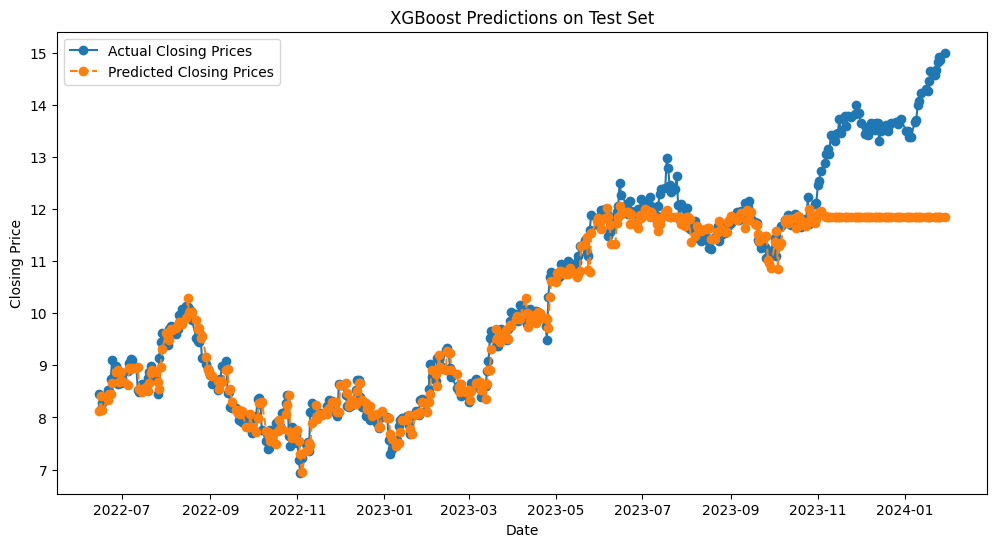

In [42]:

results_df = pd.DataFrame({'Date': X_test.index, 'Actual': y_test, 'Predicted': predictions})
results_df.set_index('Date', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Closing Prices', marker='o')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Closing Prices', linestyle='--', marker='o')
plt.title('XGBoost Predictions on Test Set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

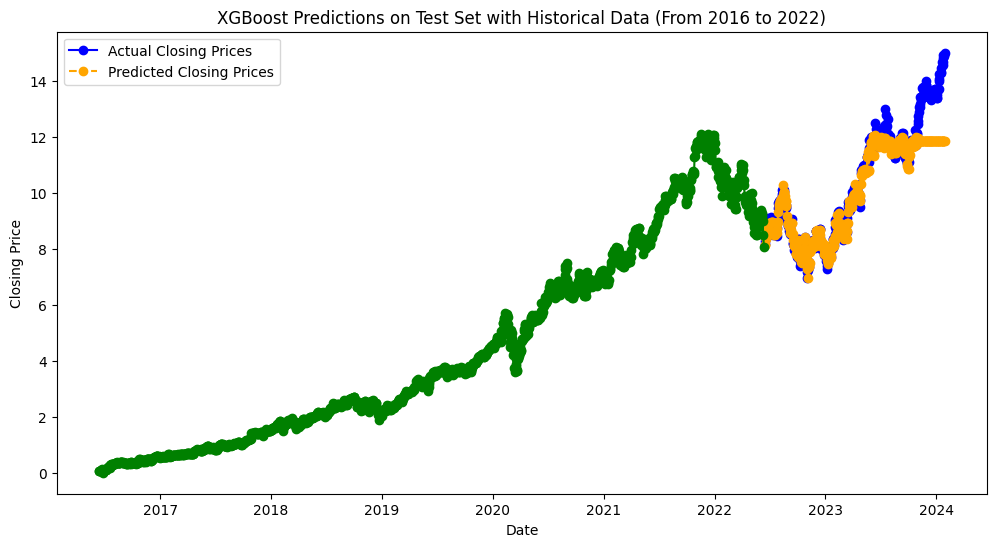

In [43]:
historical_df = df[df.index < '2022-06-14']


# Plot the actual and predicted closing prices for the test set
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual Closing Prices', marker='o', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Closing Prices', linestyle='--', marker='o', color='orange')
plt.title('XGBoost Predictions on Test Set with Historical Data (From 2016 to 2022)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()

# Plot the historical closing prices in a different color
plt.plot(historical_df.index, historical_df['Close'], label='Historical Closing Prices', marker='o', color='green')

plt.show()

In [44]:
# Evaluate the model performance
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
r2 = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")
print(f"Explained Variance: {explained_variance:.2f}")

MAE: 0.44
MSE: 0.60
RMSE: 0.78
R^2: 0.86
Explained Variance: 0.88
